<a href="https://www.kaggle.com/code/aisuko/pre-trained-models-and-transfer-learning?scriptVersionId=164458252" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

Training CNNs can take a lot of time, and a lot of data is required for that task. However, much of the time is spent to learn the best low-level filters that a network is using to extract patterns from images. A neural question arises - can we use a neural network trained on one dataset and adapt it to classifying different images without full training process?

This approach is called `transfer learning`, because transfer some knowledge from one neural network model to another. In transfer learning, we typically start with a pre-trained model, which has been trained on some large image dataset, such as `ImageNet`. Those models can already do a good job extracting different features from generic images, and in many cases just building a classifier on top of those extracted features can yield a good result.

In [1]:
import os
import torch
import warnings

if torch.cuda.is_available():
    torch_device = 'cuda'
else:
    torch_device = 'cpu'

warnings.filterwarnings('ignore')

print(torch_device)

cuda


# Cats vs. Dogs Dataset

We will solve a real-life problem of classifying images of cats and dogs. For this reason, we will use [Kaggle Cats vs. Dogs Dataset](https://www.kaggle.com/c/dogs-vs-cats) which can also be downloaded [from Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765).

Let's download this dataset and extract it into `data` directory (this process may take some time!):

In [2]:
if not os.path.exists('data/kagglecatsanddogs_5340.zip'):
    !wget -P data https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2024-02-27 00:33:42--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.123.44.196, 2a02:26f0:6d00:195::317f, 2a02:26f0:6d00:1ae::317f
Connecting to download.microsoft.com (download.microsoft.com)|104.123.44.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘data/kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   154MB/s    in 5.2s    

2024-02-27 00:33:47 (151 MB/s) - ‘data/kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [3]:
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref: # zipfile.ZipFile() is a class here we use it as a context manager to open the zip file
        zip_ref.extractall('data') # extractall() is a method of the class zipfile.ZipFile() to extract all the files in the zip file

# Pre-processing Data

Unfortunatelly, there are some corrupt image files in the dataset. We need to do quick cleaning to check for corrupted files. In order not to clobber this tutorial, we moved the code to verify dataset into a module.

In [4]:
import glob
from PIL import Image


def check_image(fn):
    try:
        im= Image.open(fn)
        im.verify() # verify() is a method of the class Image() to check if the image is broken
        return True
    except:
        return False

def check_image_dir(path):
    for fn in glob.glob(path):
        if not check_image(fn):
            print('Corrupt image: {}'.format(fn))
            os.remove(fn)

check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

Corrupt image: data/PetImages/Cat/666.jpg
Corrupt image: data/PetImages/Dog/11702.jpg


Next, let's load the images into PyTorch dataset, converting them to tensors and doing some normalization. We will apply `std_normalize` transform to bring images to the range expected by pre-trained VGG network:

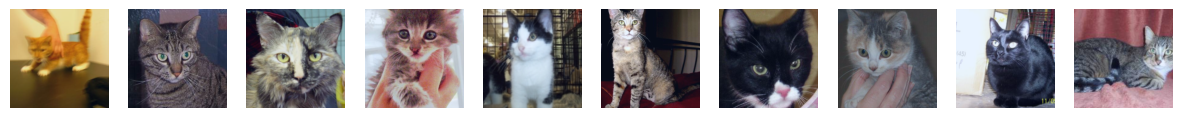

In [5]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import transforms


std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# define a transforms to reshape the input tensor and normalize it
trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    std_normalize
])

dataset = torchvision.datasets.ImageFolder('data/PetImages', transform=trans)
trainset, testset = torch.utils.data.random_split(dataset, [20000, len(dataset)-20000])


def display_dataset(dataset, n=10, classes=None):
    fig,ax=plt.subplots(1,n,figsize=(15,3))
    mn = min(dataset[i][0].min() for i in range(n))
    mx = max(dataset[i][0].max() for i in range(n))
    for i in range(n):
        ax[i].imshow(np.transpose((dataset[i][0]-mn)/(mx-mn),(1,2,0)))
        ax[i].axis('off')
        if classes:
            ax[i].set_title(classes[dataset[i][1]])

display_dataset(dataset)

# Pre-trained models

There are many different pre-trained models avaliable inside `torchvision` module, and even more models can be found on the Internet. Let's see how simplest VGG-16 model can be loaded and used:

In [6]:
vgg = torchvision.models.vgg16(pretrained=True) # vgg16 is a class here we use it as a function to get the model which is names vgg
sample_image = dataset[0][0].unsqueeze(0) # unsqueeze() is a method of the class Tensor() to add a dimension to the tensor
res = vgg(sample_image) # here we use the model as a function to get the output of the model
print(res[0].argmax()) # argmax() is a method of the class Tensor() to get the index of the maximum value in the tensor

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 316MB/s]


tensor(282)


The result that we have reveived is a number of an `ImageNet` class, which can be looked up [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). We can use the following code to automatically load this class table and return the result:

In [7]:
import json, requests

class_map = json.loads(requests.get('https://raw.githubusercontent.com/hololandscape/notebooks/main/pytorch/computer_vision/imagenet_class_index.json').text)
class_map = {int(k):v for k,v in class_map.items()}

class_map[res[0].argmax().item()] # res[0].argmax().item() is the index of the class

['n02123159', 'tiger_cat']

# Checking the Architecture

Checking the architecture of the VGG-16 networks:

In [8]:
from torchinfo import summary

summary(vgg, input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

## Dropout Layer

In addition to the layer we already know, there is also another layer type called `Dropout`. These layers act as `regularization` technique.

Regularization makes slight modifications to the learning algorithm so the model generalizes better. During training, dropout layers discard some proportion (around 30%) of the neurons in the previous layer, and training happens without them. This helps to get the optimization process out of local minima, and to distribute decisive power between neural paths, which improves overall stability of the network.

## GPU computaions

Deep neural networks, such as VGG-16 and other more modern architectures require quite a lot of computational power to run. It makes sense to use GPU acceleration, if it is available. 

In [9]:
vgg.to(torch_device)

sample_image = sample_image.to(torch_device)

vgg(sample_image).argmax()

tensor(282, device='cuda:0')

# Extracting VGG features

If we want to use VGG-16 to extract features from our images, we need the model without final classification layers. In fact, this "feature extractor" can be obtained using `vgg.features` method:

torch.Size([1, 512, 7, 7])


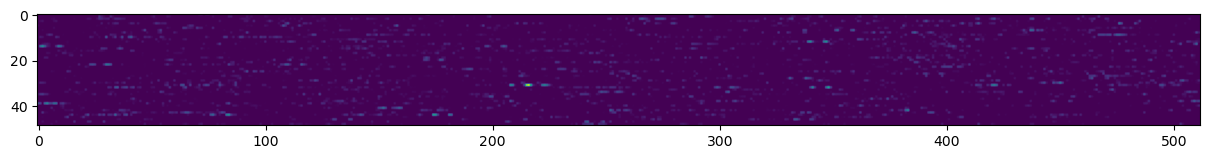

In [10]:
res = vgg.features(sample_image).cpu() # features() is a method of the class VGG() to get the output of the convolutional layers
plt.figure(figsize=(15, 3))
plt.imshow(res.detach().view(-1,512))
print(res.size())

The dimension of feature tensor is 512x7x7, but in order to visualize it we had to reshape it to 2D form.

Now let's try to see if those features can be used to classify images. Let's manually take some portion of images (800 in our case), and pre-compute their feature vectors. We will store the result in one big tensor called `feature_tensor`, and also labels into `label_tensor`:

In [11]:
bs = 8 # batch size
dl = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
num = bs*100 # number of images
feature_tensor = torch.zeros(num, 512*7*7).to(torch_device) # we use torch.zeros() to create a tensor of zeros, num is the number of images, 512*7*7 is the size of the output of the convolutional layers
label_tensor = torch.zeros(num).to(torch_device) # torch.zeros() is a function to create a tensor of zeros
i=0

for x, l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(torch_device))
        feature_tensor[i:i+bs]=f.view(bs,-1) # view() is a method of the class Tensor() to reshape the tensor
        label_tensor[i:i+bs]=l
        i+=bs
        print('.',end='')
        if i>=num:
            break

....................................................................................................

Now we can define `vgg_dataset` that takes data from the tensor, split it into training and test sets using `random_split` function, and train a small one-layer dense classifier network on top of extracted features:

In [12]:
import torch.nn as nn

def train_epoch(net, dataloader, lr=0.01, optimizer=None, loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr) # use Adam optimizer if not provided
    net.train() # put the network into training mode make sure the parameters are trainable
    total_loss,acc,count =0,0,0
    for features, labels in dataloader:
        features,labels = features.to(torch_device), labels.to(torch_device)
        optimizer.zero_grad() # reset the gradients to zero before each batch to avoid accumulation
        out=net(features) # forward pass of the mini-batch through the network to obtain the outputs
        loss=loss_fn(out,labels) # compute the loss
        loss.backward() # compute the gradients of the loss with respect to all the parameters of the network
        optimizer.step() # update the parameters of the network using the gradients to minimize the loss
        total_loss+=loss # accumulate the loss for inspection
        _,preds=torch.max(out,dim=1) # compute the predictions to obtain the accuracy
        acc+=(preds==labels).sum() # accumulate the correct predictions
        count+=len(labels) # accumulate the total number of examples
    return total_loss.item()/count, acc.item()/count # return the loss and accuracy

def validate(net, dataloader, loss_fn=nn.NLLLoss()):
    net.eval() # put the network into evaluation mode to deactivate the dropout layers
    count,acc,loss =0,0,0
    with torch.no_grad(): # deactivate autograd to save memory and speed up computations
        for features, labels in dataloader:
            features,labels = features.to(torch_device), labels.to(torch_device)
            out=net(features) # forward pass of the mini-batch through the network to obtain the outputs
            loss += loss_fn(out,labels) # compute the loss
            preds=torch.max(out,dim=1)[1] # compute the predictions to obtain the accuracy
            acc+=(preds==labels).sum() # accumulate the correct predictions
            count+=len(labels) # accumulate the total number of examples
    return loss.item()/count, acc.item()/count # return the loss and accuracy

def train(net, train_loader, test_loader, optimizer=None, lr=0.01, epochs=10, loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr) # use Adam optimizer if not provided
    res = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc':[]}
    for ep in range(epochs):
        tl, ta = train_epoch(net, train_loader, optimizer=optimizer,lr=lr, loss_fn=loss_fn)
        vl,va = validate(net, test_loader, loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

def plot_results(hist):
    plt.figure(figsize=(15,5)) # figure is used to create a new figure
    plt.subplot(121) # subplot is used to create a new subplot on a grid
    plt.plot(hist['train_acc'], label='Training acc')
    plt.plot(hist['val_acc'], label='Validation acc')
    plt.legend() # legend is used to add a legend to the plot
    plt.subplot(122) # plot the loss
    plt.plot(hist['train_loss'], label='Training loss')
    plt.plot(hist['val_loss'], label='Validation loss')
    plt.legend()


In [13]:
# TensorDataset() is a class to create a dataset from tensors of features and labels. Here we use `torch.long` to convert the labels to long type in order to use them in the loss function.
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor, label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset, [700, 100])

train_loader =torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader =torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=True)

net = torch.nn.Sequential(
    torch.nn.Linear(512*7*7, 2),
    torch.nn.LogSoftmax(dim=0)
).to(torch_device)

history = train(net,train_loader,test_loader)

Epoch  0, Train acc=0.721, Val acc=0.650, Train loss=2.125, Val loss=3.219
Epoch  1, Train acc=0.817, Val acc=0.770, Train loss=3.257, Val loss=4.082
Epoch  2, Train acc=0.824, Val acc=0.720, Train loss=3.554, Val loss=4.128
Epoch  3, Train acc=0.794, Val acc=0.800, Train loss=3.356, Val loss=3.300
Epoch  4, Train acc=0.801, Val acc=0.730, Train loss=3.753, Val loss=2.899
Epoch  5, Train acc=0.760, Val acc=0.780, Train loss=3.812, Val loss=3.076
Epoch  6, Train acc=0.757, Val acc=0.760, Train loss=3.987, Val loss=2.991
Epoch  7, Train acc=0.761, Val acc=0.800, Train loss=3.974, Val loss=3.094
Epoch  8, Train acc=0.734, Val acc=0.840, Train loss=4.006, Val loss=2.987
Epoch  9, Train acc=0.743, Val acc=0.790, Train loss=4.122, Val loss=3.236


The result is great, we can distinguish  between a cat and a dog with almost 98% probability! However, we have only tested this aproach on a small subset of all images, because manual feature extraction seems to take a lot of time.


# Transfer learning

We can also avoid manually pre-computing the features by using the original VGG-16 network as a whole during training> Let's look at the VGG-16 object structure:

In [14]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

You can see that the network contains:
* feature extractor `features`, comprised of a number of convolutional and pooling layers
* average pooling layer `avgpool`
* final `classifier`, consisting of several dense layers, which turns 25088 input features into 1000 classes (which is the number of classes in ImageNet)

To train the end-to-end model that will classify our dataset,  we need to:
* `replace the final classifier` with the one that will produce required number of classes. In our case, we can use one `Linear` layer with 25088 inputs and 2 output neurons.
* `freeze weights of convolutional feature extractor`, so that they are no trained. It is recommended to initially do this freezing, because otherwise untrained classifier layer can destroy the original pre-trained weights of convolutional extractor. Freezing weights can be accomplished by setting `requires_grad` property of all parameters of `False`

## Replace the Final Classifier and Freeze Weights

In [15]:
vgg.classifier = torch.nn.Linear(25088,2).to(torch_device)

for x in vgg.features.parameters():
    x.requires_grad=False

summary(vgg, input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 2]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]    

As you cane see from the summary, this model contain around 15 million total parameters, but only 50k of them are trainable - those are the weights of classification layer. That is good, because we are able to fine-tune smaller number of parameters with smaller number of examples.

Now, let's train the model using our original dataset. This process will take a long time, so we will use `train_long` function that will print some intermediate results without waiting for thr end of epoch. It is highly recommended to run this training on GPU-enabled computer.

In [16]:
def train_long(net, train_loader, test_loader, epochs=5, lr=0.01, optimizer=None, loss_fn=nn.NLLLoss(), print_freq=10):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr) # use Adam optimizer if not provided
    for epoch in range(epochs):
        net.train() # put the network into training mode make sure the parameters are trainable
        total_loss,acc,count =0,0,0
        for i, (features, labels) in enumerate(train_loader):
            lbls = labels.to(torch_device)
            optimizer.zero_grad() # reset the gradients to zero before each batch to avoid accumulation
            out=net(features.to(torch_device)) # forward pass of the mini-batch through the network to obtain the outputs
            loss = loss_fn(out, lbls) # compute the loss
            loss.backward() # compute the gradients of the loss with respect to all the parameters of the network
            optimizer.step() # update the parameters of the network using the gradients to minimize the loss
            total_loss+=loss # accumulate the loss for inspection
            _,preds=torch.max(out,dim=1) # compute the predictions to obtain the accuracy
            acc+=(preds==lbls).sum() # accumulate the correct predictions
            count+=len(lbls) # accumulate the total number of examples
            if i%print_freq==0:
                print(f'Epoch {epoch}, iter {i}, loss={total_loss.item()/count:.3f}, acc={acc.item()/count:.3f}')
        vl, va = validate(net, test_loader, loss_fn=loss_fn)
        print(f'Epoch {epoch}, val_loss={vl:.3f}, val_acc={va:.3f}')

trainset, testset = torch.utils.data.random_split(dataset, [20000, len(dataset)-20000])
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)

train_long(vgg, train_loader, test_loader, loss_fn=torch.nn.CrossEntropyLoss(), epochs=1, print_freq=90) # print_freq=90 means print the results every 90 batches

Epoch 0, iter 0, loss=0.047, acc=0.562
Epoch 0, iter 90, loss=0.068, acc=0.954
Epoch 0, iter 180, loss=0.098, acc=0.961
Epoch 0, iter 270, loss=0.100, acc=0.963
Epoch 0, iter 360, loss=0.095, acc=0.967
Epoch 0, iter 450, loss=0.103, acc=0.968
Epoch 0, iter 540, loss=0.107, acc=0.969
Epoch 0, iter 630, loss=0.117, acc=0.969
Epoch 0, iter 720, loss=0.129, acc=0.970
Epoch 0, iter 810, loss=0.127, acc=0.971
Epoch 0, iter 900, loss=0.124, acc=0.972
Epoch 0, iter 990, loss=0.139, acc=0.972
Epoch 0, iter 1080, loss=0.135, acc=0.973
Epoch 0, iter 1170, loss=0.134, acc=0.974
Epoch 0, val_loss=0.156, val_acc=0.983


## Saving the Model

In [17]:
torch.save(vgg, 'data/cats_dogs.pth')

# load model from the file anytime
# vgg= torch.load('data/cats_dogs.pth')

# Fine-tuning transfer learning

We have trained the final classifier layer to classify images in our own dataset. However, we did not re-train the feature extractor, and our model relied on the features that the model has learned on ImageNet data. If your objects visually differ from ordinary ImageNet images, this combination of features might not work best. Thus it makes sense to start training convolutional layers as well.

To do that, we can unfreeze the convolutional filter parameters that we have previously frozen.

**Note: It is important that we freeze parameters first and perform several epochs of training in order to stabilize weights in the classification layer. If we immediately start training end-to-end network with unfrozen parameters, large errors are likely to destroy the pre-trained weights in the convolutional layers.**

In [18]:
for x in vgg.features.parameters():
    x.requires_grad=True

After unfreezing, we can do a few more epochs of training. You can also select lower learning rate, in order to minimize the impact on the pre-trained weights. However, even with low learning rate, you can expect the accuracy to drop in the beginning of the training, until finally reaching slightly higher level than  in the case of fixed weights.

**Note: This training happens mush slower, because we need to propagate gradients back through many layers of the network! You may want to watch the first few minibatches to see the tendency, and then stop the computation.**

In [19]:
train_long(vgg, train_loader, test_loader, loss_fn=torch.nn.CrossEntropyLoss(), epochs=1, print_freq=90, lr=0.0001)

Epoch 0, iter 0, loss=0.000, acc=1.000
Epoch 0, iter 90, loss=0.263, acc=0.892
Epoch 0, iter 180, loss=0.151, acc=0.903
Epoch 0, iter 270, loss=0.109, acc=0.911
Epoch 0, iter 360, loss=0.086, acc=0.919
Epoch 0, iter 450, loss=0.072, acc=0.925
Epoch 0, iter 540, loss=0.061, acc=0.930
Epoch 0, iter 630, loss=0.054, acc=0.932
Epoch 0, iter 720, loss=0.048, acc=0.936
Epoch 0, iter 810, loss=0.044, acc=0.938
Epoch 0, iter 900, loss=0.040, acc=0.940
Epoch 0, iter 990, loss=0.037, acc=0.942
Epoch 0, iter 1080, loss=0.035, acc=0.944
Epoch 0, iter 1170, loss=0.032, acc=0.945
Epoch 0, val_loss=0.005, val_acc=0.967


# Other computer vision models

VGG-16 is one of the simplest computer vision architectures. `torchvision` package provides many ,pre pre-trained networks. The most frequently used one among thise are `ResNet` architectures, developed by Microsoft, and `Inception` by Google. For example, let's explore the architecture of the simplest ResNet-18 model (ResNet is a family of model with different depth, you can try experimenting with ResNet-151 if you want to see what a really deep model looks like):

In [20]:
resnet = torchvision.models.resnet18()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Batch Normalization

This network contains yet another type of layer: `Batch normalization`. The idea of batch mnormalization is to bring values that flow thorugh the neural network to right interval. Usually neural networks work best when all values are in the range of [-1,1] or [0,1], and that is the reason that we scale/normalize our input data accordingly. However, during training of a deep network, it can happen that values get significantly out of this range, which makes training problematic. Batch normalization layer computes average and standards deviation for all values of the current minibatch, and uses them to normalize the signal before passing it through a neural network layer. This significantly improves the stability of deep networks.


Using transfer learning, we were able to quickly put together a classifier for our custom object classification task, and achieve high accuracy. However, this example was not completely fair, because original VGG-16 network was pre-trained to recognize cats and dogs, and thus we were just reusing mosr of the patterns that were already presernt in the network. You can expect lower accuracy on more  exotic domain-specific obejcts, such as details on production line in a plant, or different tree leaves.

You can see that more complex tasks taht we are solving now require higher computational power, and cannot be easily solved on the CPU.